In [8]:
import torch
import torch.nn as nn
from helchriss.utils import stprint

# Domain Definition
create function domains and evaluate using executor.

In [9]:
from domains.math.integer_domain import integer_executor
r_int = integer_executor.evaluate("plus(one(), two())", {})
stprint(r_int)

from domains.spatial.circle_domain import circle_executor
r_circ = circle_executor.evaluate("area(unit_circle())", {})
stprint(r_circ)

r_int = Value:[3.0000]-float P:[1.0] (Value)
r_circ = Value:[tensor([3.1416])]-float P:[1.0] (Value)


# Rewrite Rules
   1. a `LocalFrame` module is several rewrite rules that shares the same arg writer.
   2. a NeuralRewriter module compose of a dictionary of LocalFrame.

In [3]:
from core.metaphors.rewrite import NeuralRewriter, LocalFrame
rewriter = NeuralRewriter()
#frame = LocalFrame()
#rewriter.add_frame("rw", frame)

# Rewrite Executor
**Property**
1) it stores a `ExecutorGroup` that can look up domain functions.
2) a rewriter of class `NeuralRewriter`, is stores all the rewrite rules learned.

**Methods**
1) `evaluate(expr, grounding)` method takes a expression and grounding as input, then calculate the exepected output of an expression over all rewrite rules. The output should be a single value as the exepected output.
2) `infer_rewrite` method takes an expression (and grounding) as input and propose several rewrite rules

In [4]:
from core.metaphors.executor import ExecutorGroup, RewriteExecutor
from helchriss.knowledge.symbolic import Expression
executor = RewriteExecutor(ExecutorGroup([circle_executor, integer_executor]))
result = executor.evaluate("plus:Integer(one:Integer(), two:Integer())", {})
print(result)

from helchriss.dsl.dsl_types import AnyType
#executor.base_executor.register_function("idd", [AnyType],AnyType, nn.Identity())

expr = "partial_overlap:Circle(N:Integer(), unit_circle:Circle())"
expr = Expression.parse_program_string(expr)
hypothesis = executor.infer_rewrite_expr(expr)
stprint(hypothesis)
executor.add_metaphors(hypothesis) ### add rewrite exprs


executor.evaluate(expr, grounding = {})


13 14:50:37 WRN The input domain is empty, creating an empty domain
13 14:50:37 WRN The input domain is empty, creating an empty domain


Value:[3.0000]-float P:[1.0]
hypothesis = list (length: 1)[
  list (length: 4)[
    0: 'partial_overlap:Circle'
    list (length: 2)[
      0: Embedding[circle, 3] (EmbeddingType)
      1: Embedding[circle, 3] (EmbeddingType)
    ]
    list (length: 2)[
      0: Embedding[set, 32] (EmbeddingType)
      1: Embedding[circle, 3] (EmbeddingType)
    ]
    3: bool (TypeBase)
  ]
]


Value:[tensor([-1.5521], grad_fn=<AddBackward0>)]-bool P:[1.0]

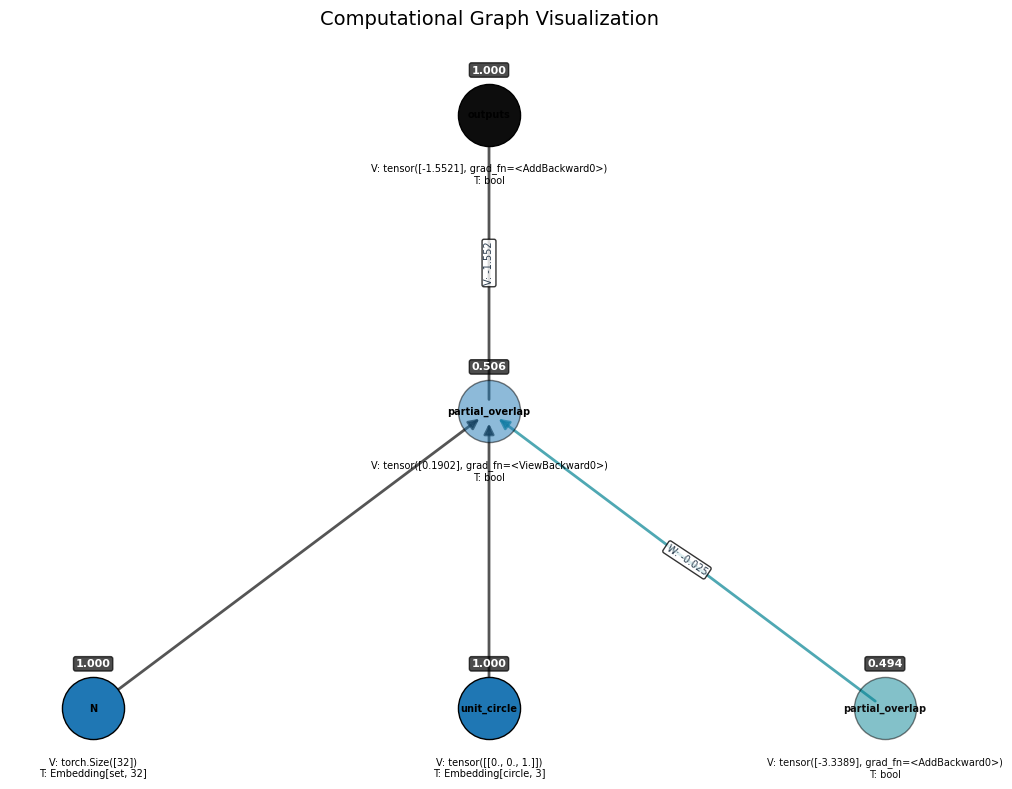

before training


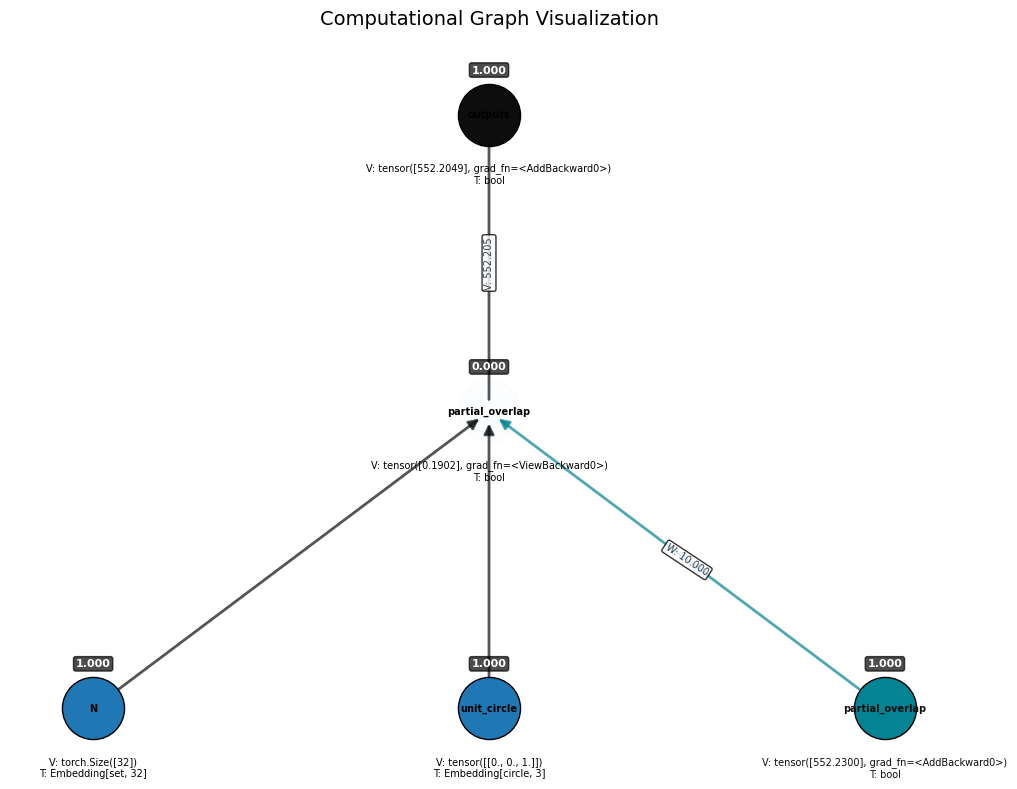

we are done here.


In [5]:

expr = "partial_overlap:Circle(N:Integer(), unit_circle:Circle())"
expr = Expression.parse_program_string(expr)

executor.base_executor.freeze_extended(False)
optim = torch.optim.Adam(executor.parameters(), lr = 1e-3)

executor.display("compute_tree_before")
print("before training")

for epoch in range(100):
    result = executor.evaluate(expr, grounding = {})
    loss = torch.nn.functional.binary_cross_entropy_with_logits(torch.tensor([1.0]), result.value)
    optim.zero_grad()
    loss.backward()
    optim.step()

executor.evaluate(expr, grounding = {})



executor.display("compute_tree_after")
print("we are done here.")


In [14]:
from core.model import MetaLearner
from core.utils import stmetaphors

learner = MetaLearner([circle_executor, integer_executor])
learner.load_ckpt("outputs/checkpoints/sizer")
### load the meta learner from the pretrained-checkpoint

### check composition generalization of fixed lexicon entries
from core.grammar.lexicon import LexiconEntry, CCGSyntacticType, SemProgram
def_entries = [
    LexiconEntry("red", 
                 CCGSyntacticType.syntatic_type_from_string("state"),
                 SemProgram("unit_circle:Circle", [], []) )
]
learner.parser.purge_entry("red", p = 0.5, abs = False)
learner.parser.add_word_entries("red", def_entries)


query = "red smaller two"
grounding = {}
exprs = learner.parse_display(query, topK = 2,forced = 1)

exprs = learner.maximal_parse(query, forced = 1)[:2]
metas = learner.infer_metaphor_expressions([expr[0] for expr in exprs])

print(stmetaphors(metas))

learner.execute_display(query, grounding, topK = 6, forced = 1)

14 17:29:56 WRN The input domain is empty, creating an empty domain
14 17:29:56 WRN The input domain is empty, creating an empty domain
14 17:29:56 WRN The input domain is empty, creating an empty domain
14 17:29:56 WRN The input domain is empty, creating an empty domain


bool\Embedding[circle, 3]\Embedding[circle, 3] λx0.x1.partial_overlap:Circle()
bool/Embedding[circle, 3]\Embedding[circle, 3] λx0.x1.disconnected:Circle()
float\float/float λx0.x1.plus:Integer()
bool/Embedding[circle, 3]/Embedding[circle, 3] λx0.x1.disconnected:Circle()
bool\Embedding[circle, 3] λx1.non_tangential_proper_part_inverse:Circle(unit_circle:Circle())
bool\Embedding[circle, 3]/Embedding[circle, 3] λx0.x1.tangential_proper_part_inverse:Circle()
bool\Embedding[circle, 3]\Embedding[circle, 3] λx0.x1.tangential_proper_part:Circle()
bool\Embedding[circle, 3]/Embedding[circle, 3] λx0.x1.tangential_proper_part:Circle()
float/float λx1.plus:Integer(three:Integer())
float area:Circle(unit_circle:Circle())
bool\Embedding[circle, 3]\Embedding[circle, 3] λx0.x1.disconnected:Circle()
float\float λx1.plus:Integer(two:Integer())
bool\Embedding[circle, 3] λx1.disconnected:Circle(unit_circle:Circle())
bool\Embedding[circle, 3] λx1.partial_overlap:Circle(unit_circle:Circle())
float/Embedding[

'+------------------+-------------+----------------------------------------------------------------+\n| parse-tree       |      weight | answer                                                         |\n+==================+=============+================================================================+\n| smaller          | 0.625529    | \x1b\x1bValue\x1b\x1b:[\x1b\x1btensor([0.0937], grad_fn=<AddBackward0>)\x1b\x1b[97m]-\x1b\x1bbool\x1b \x1b\x1bP\x1b\x1b:[\x1b\x1b1.0\x1b\x1b[97m]\x1b  |\n| ├── one          |             |                                                                |\n| └──  N           |             |                                                                |\n+------------------+-------------+----------------------------------------------------------------+\n| bigger           | 0.374471    | \x1b\x1bValue\x1b\x1b:[\x1b\x1btensor([-0.7167], grad_fn=<AddBackward0>)\x1b\x1b[97m]-\x1b\x1bbool\x1b \x1b\x1bP\x1b\x1b:[\x1b\x1b1.0\x1b\x1b[97m]\x1b |\n| ├── N        

In [13]:
 ### Display the Lexicon entries learned
for word in query.split(" "):
    learner.parser.display_word_entries(word)
    pass

+--------+--------+----------------------+----------+
| word   | type   | program              |   weight |
+========+========+======================+==========+
| red    | float  | one:Integer()        |  4.78728 |
+--------+--------+----------------------+----------+
| red    | state  | unit_circle:Circle() |  0       |
+--------+--------+----------------------+----------+
+---------+------------------+--------------------------+----------+
| word    | type             | program                  |   weight |
+=========+==================+==========================+==========+
| smaller | bool/float\float | λx0.x1.smaller:Integer() | 10.1816  |
+---------+------------------+--------------------------+----------+
| smaller | bool\float/float | λx0.x1.bigger:Integer()  |  9.66854 |
+---------+------------------+--------------------------+----------+
+--------+--------------------+-------------+----------+
| word   | type               | program     |   weight |
+========+===============

In [ ]:
### Create Prototype of Meta Learner
#!python main.py --command=create_prototype

In [ ]:
#!python main.py --command=train_mcl --epochs=3500 --lr=5e-3 \
#    --load_model=summer --save_model=sizer --dataset_name=IntSum

# Grounding Concepts
MetaLearner can learn to ground concepts using various sources.

In [ ]:
### use the model to learn to grounding using vqa and descriptive sentence.

# Planning with Actions

In [ ]:
### this can perform planning with various concepts.

# Solving CCSP Config
solve a ccsp configuration using the `make ...` descripption. Also allowed to training etc.

In [ ]:
from core.spatial.energy_graph import PointEnergyMLP
from core.spatial.diffusion import samples, ScheduleLogLinear, training_loop


constraints = {
        "externally_connected": [3,3],
        "partial_overlap": [3,3],
        "equal": [3,3],
        "disconnected": [3,3],
        "tangential_proper_part": [3,3],
        "non_tangential_proper_part": [3,3],
        "tangential_proper_part_inverse": [3,3],
        "non_tangential_proper_part_inverse": [3,3]
    }

state_path = "outputs/checkpoints/circular_state.pth"
device = "mps"

model = PointEnergyMLP(constraints, dim = 3)
model.load_state_dict(torch.load(state_path, map_location = device))


from datasets.ccsprim.circles_data import get_constraint_dataset
loader = get_constraint_dataset()
schedule = ScheduleLogLinear(N=300, sigma_min=0.005, sigma_max=10)
#trainer  = training_loop(loader, model, schedule, epochs=3)
#losses   = [ns.loss.item() for ns in trainer]

batchsize = 4

cond = {"edges":[
    (0, 1, "partial_overlap"),
    (1, 2, "disconnected"),
    (0, 2, "disconnected"),
    (2, 3, "partial_overlap"ww)
    ]}
xt = torch.randn([1,batchsize,3]) 
*xt, x0  = samples(model, schedule.sample_sigmas(300), gam=2, cond = cond, batchsize = batchsize, xt = xt)

print("Solution:")
print(x0[0].cpu().detach().numpy())



/opt/anaconda3/envs/prototype/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/var/folders/ms/qbhhrxd119555wkjspljcjcc0000gn/T/ipykernel_21134/1880323776.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe

Solution:
[[-4.426424   -2.9276357   0.5304432 ]
 [-3.9170203  -2.4398983   0.79786426]
 [ 3.5022113   1.847368    0.01778674]
 [ 3.163947    1.2518996   0.5926588 ]]


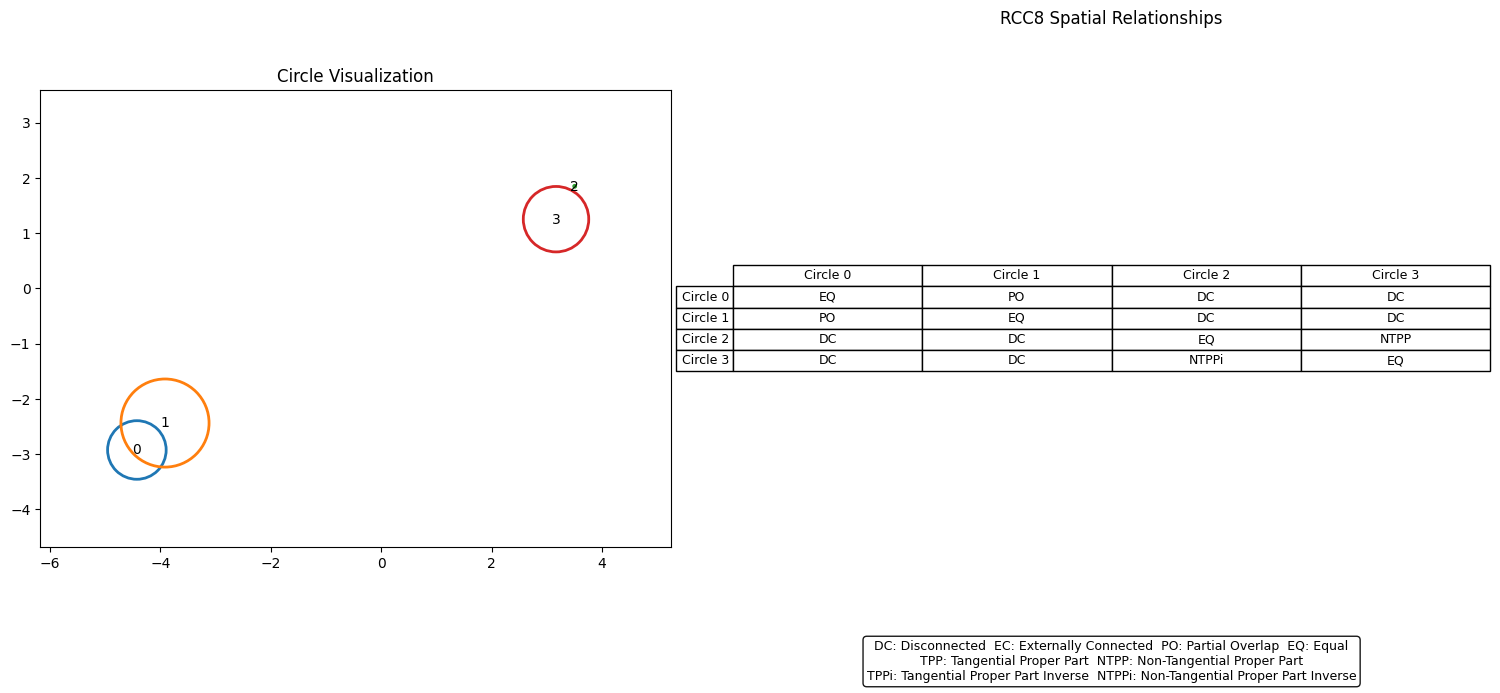

In [7]:
from domains.spatial.circle_domain import circle_executor
circle_executor.visualize(x0[0].cpu())